<a href="https://colab.research.google.com/github/maikkrs/C/blob/main/Entrenamiento_BETO_EmoEvent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Entrenamiento de modelo BETO con EmoEvent en Colab
Este notebook entrena un modelo BETO para clasificación de emociones usando los archivos `train.tsv` y `dev.tsv`.

Instalar dependencias

In [28]:
!pip install transformers datasets scikit-learn matplotlib

In [29]:
# Importar
import pandas as pd
import numpy as np
import re
import random

from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Config. semilla
random.seed(42)
np.random.seed(42)


In [30]:
# Cargar datasets
train_df = pd.read_parquet("/content/drive/MyDrive/Seminario Pia/ds/train.parquet")
val_df = pd.read_parquet("/content/drive/MyDrive/Seminario Pia/ds/validation.parquet")
test_df = pd.read_parquet("/content/drive/MyDrive/Seminario Pia/ds/test.parquet")

# Usar solo la primera etiqueta
train_df["label"] = train_df["labels"].apply(lambda x: x[0])
val_df["label"] = val_df["labels"].apply(lambda x: x[0])
test_df["label"] = test_df["labels"].apply(lambda x: x[0])

# Limpiar texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s¡!¿?.,áéíóúüñ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["text"] = train_df["text_es"].apply(clean_text)
val_df["text"] = val_df["text_es"].apply(clean_text)
test_df["text"] = test_df["text_es"].apply(clean_text)


In [31]:
# Crear mapeos de etiquetas
unique_labels = sorted(set(train_df["label"].unique()))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

train_df["label"] = train_df["label"].map(label2id)
val_df["label"] = val_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

# Convertir a Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["text", "label"]])


In [32]:
# Modelo BETO
#model_name = "dccuchile/bert-base-spanish-wwm-cased"
model_name = "bertin-project/bertin-roberta-base-spanish"


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label={int(i): str(id2label[int(i)]) for i in id2label},
    label2id={str(v): int(k) for k, v in label2id.items()}
)


# Tokenización
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function)
val_dataset = val_dataset.map(tokenize_function)
test_dataset = test_dataset.map(tokenize_function)


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

## **Métricas y argumentos de entrenamiento**

In [33]:
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(pred.label_ids, preds)
    f1 = f1_score(pred.label_ids, preds, average="macro")
    return {
        "accuracy": acc,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    seed=42
)


Entrenador y entrenamiento

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
z
trainer.train()
trainer.save_model("/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin")
tokenizer.save_pretrained("/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin")


<ipython-input-34-78852a48ca87>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: miguelrdzs02 (miguelrdzs02-universidad-autonoma-de-nuevo-leon) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.584100,1.513018,0.557132,0.399952
2,1.232900,1.490891,0.559160,0.419043
3,0.697700,1.720111,0.533911,0.409836
4,0.297300,2.150525,0.526723,0.412196


('/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/tokenizer_config.json',
 '/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/special_tokens_map.json',
 '/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/vocab.json',
 '/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/merges.txt',
 '/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/added_tokens.json',
 '/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin/tokenizer.json')

In [35]:
# 📊 Evaluar el modelo en el conjunto de prueba
results = trainer.evaluate(test_dataset)

print("Resultados en test:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Resultados en test:
eval_loss: 1.5218
eval_accuracy: 0.5504
eval_f1: 0.4079
eval_runtime: 37.6753
eval_samples_per_second: 144.0460
eval_steps_per_second: 9.0240
epoch: 4.0000


In [36]:
import numpy as np
import pandas as pd

# 🔮 Obtener predicciones
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# 🧾 Extraer textos y etiquetas reales
texts = test_dataset["text"]
labels_real = [id2label[i] for i in predictions.label_ids]
labels_pred = [id2label[i] for i in preds]

# 📄 Crear DataFrame
df_pred = pd.DataFrame({
    "text": texts,
    "label_real": labels_real,
    "label_predicha": labels_pred
})

# 💾 Guardar como CSV
df_pred.to_csv("/content/drive/MyDrive/Seminario Pia/predicciones_test_bertin.csv", index=False, encoding="utf-8")
print("✅ Predicciones guardadas en 'predicciones_test.csv'")


✅ Predicciones guardadas en 'predicciones_test.csv'


In [37]:
##Cargar modelo entrenado y tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin", local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin", local_files_only=True)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


In [38]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🧠 Etiquetas en español
label_names_es = [
    "admiración", "diversión", "enojo", "molestia", "aprobación", "cuidado", "confusión", "curiosidad",
    "deseo", "decepción", "desaprobación", "asco", "vergüenza", "emoción", "miedo",
    "gratitud", "duelo", "alegría", "amor", "nerviosismo", "optimismo", "orgullo", "realización",
    "alivio", "remordimiento", "tristeza", "sorpresa", "neutral"
]
id2label = {i: name for i, name in enumerate(label_names_es)}

# 📥 Cargar test.parquet
df_test = pd.read_parquet("/content/drive/MyDrive/Seminario Pia/ds/test.parquet")
df_test["label"] = df_test["labels"].apply(lambda x: x[0])

# 🧽 Limpiar texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s¡!¿?.,áéíóúüñ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_test["text"] = df_test["text_es"].apply(clean_text)

# 🧠 Tokenizar manualmente
model_path = "/content/drive/MyDrive/Seminario Pia/ds/modelo_bertin"
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
inputs = tokenizer(list(df_test["text"]), truncation=True, padding="max_length", max_length=128, return_tensors="pt")

# 🎯 Crear DataLoader
labels_tensor = torch.tensor(df_test["label"].values)
dataset = TensorDataset(inputs["input_ids"], inputs["attention_mask"], labels_tensor)
loader = DataLoader(dataset, batch_size=16)

# 🧠 Cargar modelo entrenado
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# 🔮 Predecir
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


<Figure size 1000x800 with 0 Axes>

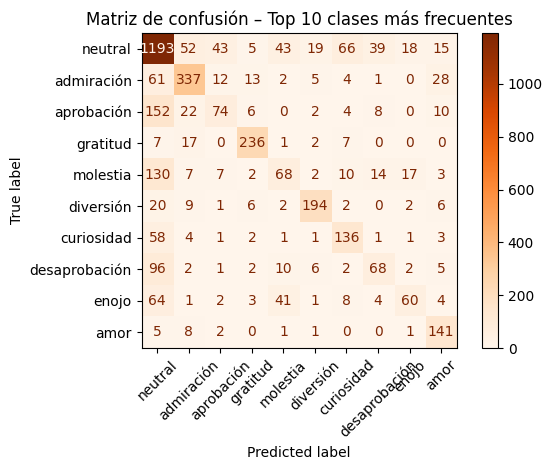

In [39]:
import numpy as np
from collections import Counter

# 📊 Contar frecuencia de etiquetas reales
conteo = Counter(all_labels)
top_10_ids = [item[0] for item in conteo.most_common(10)]
top_10_labels = [id2label[i] for i in top_10_ids]

# 🧮 Filtrar matriz de confusión
cm_top = confusion_matrix(all_labels, all_preds, labels=top_10_ids)

# 📈 Mostrar matriz de confusión solo para top 10
disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=top_10_labels)

plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Oranges")
plt.title("Matriz de confusión – Top 10 clases más frecuentes")
plt.tight_layout()
plt.show()


## SEPARADOR


In [ ]:
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 🧠 Emociones en español
label_names_es = [
    "admiración", "diversión", "enojo", "molestia", "aprobación", "cuidado", "confusión", "curiosidad",
    "deseo", "decepción", "desaprobación", "asco", "vergüenza", "emoción", "miedo",
    "gratitud", "duelo", "alegría", "amor", "nerviosismo", "optimismo", "orgullo", "realización",
    "alivio", "remordimiento", "tristeza", "sorpresa", "neutral"
]
id2label = {i: name for i, name in enumerate(label_names_es)}

# ✅ Cargar modelo y tokenizer entrenado
model = AutoModelForSequenceClassification.from_pretrained("modelo_goemotions")
tokenizer = AutoTokenizer.from_pretrained("modelo_goemotions")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# 🧼 Limpieza de texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s¡!¿?.,áéíóúüñ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 🔮 Función de predicción
def predecir_emocion(texto):
    texto_limpio = clean_text(texto)
    inputs = tokenizer(texto_limpio, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = logits.argmax(dim=1).item()
        emocion = id2label[pred_id]

    return emocion

# 🧪 Probar desde input
texto = input("📝 Escribe un texto para clasificar su emoción: ")
emocion = predecir_emocion(texto)
print(f"🔍 Emoción predicha: **{emocion.upper()}**")


Escribe un texto para clasificar su emoción: Intenté estar en paz, pero el silencio me gritaba demasiado fuerte.
🔍 Emoción predicha: sadness
